In [1]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

import pyspark.sql.functions as sqlf
from pyspark.sql.functions import year, month, to_date
from pyspark.sql.functions import min, max
from pyspark.sql.functions import mean, stddev
from pyspark.sql.functions import format_number
from pyspark.sql.functions import avg


from pyspark.sql.types import DateType

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Warm-Up!

In [2]:
spark = SparkSession.builder \
    .appName("StockMarketAnalysis") \
    .getOrCreate()


In [3]:
stocks_df = spark.read.csv("stocks.csv", header=True)

stocks_df.printSchema()

print(stocks_df.count())
stocks_df.show()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Adj Close: string (nullable = true)

1762
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|          

In [4]:
filtered_by_closing_price = stocks_df.filter(stocks_df["Close"] < 500)

selected_columns_df = filtered_by_closing_price.select("Open", "Close", "Volume")

def show_df_info(df):
    df_count = df.count()
    print(f"Number of rows: {df_count}")
    df.show()

show_df_info(selected_columns_df)

Number of rows: 1359
+------------------+------------------+---------+
|              Open|             Close|   Volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
|        208.330002|        215.039995|182501900|
|        214.910006|            211.73|153038200|
|        212.079994|        208.069996|152038600|
|206.78000600000001|            197.75|220441900|
|202.51000200000001|        203.070002|266424900|
|205.95000100000001|        205.940001|466777500|
|        206.849995|        2

In [5]:
filtered_records_df = stocks_df.filter((stocks_df["Open"] > 200) & (stocks_df["Close"] < 200))

show_df_info(filtered_records_df)

Number of rows: 3
+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+



In [6]:
stocks_df_with_year = stocks_df.withColumn("Year", year("Date"))
show_df_info(stocks_df_with_year)

Number of rows: 1762
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2

In [7]:
min_volume_by_year = stocks_df_with_year.groupBy("Year").agg(min("Volume").alias("minVolume"))
show_df_info(min_volume_by_year)

Number of rows: 7
+----+---------+
|Year|minVolume|
+----+---------+
|2010|100901500|
|2011|100110500|
|2012|100023000|
|2013|100345700|
|2014|100092000|
|2015|101217500|
|2016|110888700|
+----+---------+



In [8]:
stocks_df_with_year_month = stocks_df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
max_low_price = stocks_df_with_year_month.groupBy("Year", "Month").agg(max("Low").alias("maxLow"))

show_df_info(max_low_price)

Number of rows: 84
+----+-----+------------------+
|Year|Month|            maxLow|
+----+-----+------------------+
|2010|    1|        213.249994|
|2010|    2|        202.000004|
|2010|    3|        234.459999|
|2010|    4|268.19001000000003|
|2010|    5|        262.880009|
|2010|    6|        271.499992|
|2010|    7|        260.300003|
|2010|    8|        260.549995|
|2010|    9|        291.009998|
|2010|   10|        314.289997|
|2010|   11|        316.759987|
|2010|   12|        325.099991|
|2011|    1|        344.440006|
|2011|    2|             360.5|
|2011|    3|        357.750004|
|2011|    4|        350.300007|
|2011|    5|        346.880009|
|2011|    6|        344.649998|
|2011|    7|399.67998900000003|
|2011|    8|        392.369995|
+----+-----+------------------+
only showing top 20 rows



In [9]:
mean_stddev_high_df = stocks_df.agg(
    format_number(mean("High"), 2).alias("MeanHigh"), 
    format_number(stddev("High"), 2).alias("StdDevHigh")
)
mean_stddev_high_df.show(truncate=False)

+--------+----------+
|MeanHigh|StdDevHigh|
+--------+----------+
|315.91  |186.90    |
+--------+----------+



# Main Task

In [10]:
spark = SparkSession.builder \
    .appName("SpotifyAnalysis") \
    .getOrCreate()

In [11]:
spotify_data = spark.read.parquet("spotify.parquet")

## Data Exploration

In [12]:
spotify_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



In [13]:
spotify_data.describe().show()

+-------+--------------------+----------+---------------+--------------------+---------------------------+--------------------+-----------------+-------------------+-------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|                  id|      name|          album|            album_id|                    artists|          artist_ids|     track_number|        disc_number|       danceability|             energy|              key|           loudness|               mode|        speechiness|       acousticness|   instrumentalness|           liveness|            valence|             tempo|       duration_ms|    time_signature|              year|      release_date|
+-------+--------------------+----------+---------------+--------------------+----

## Clean Data

In [14]:
columns_to_drop = ['id', 'album_id', 'artist_ids',]
spotify_data_clean = spotify_data.drop(*columns_to_drop)


In [15]:
spotify_data_clean = spotify_data_clean.withColumn(
    "release_date",
    spotify_data_clean['release_date'].cast(DateType()))

In [16]:
spotify_data_clean = spotify_data_clean.na.drop()

In [17]:
spotify_data_clean = spotify_data_clean.withColumn("duration_min", sqlf.col("duration_ms")/60000)

In [18]:
spotify_data_clean.show()

+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+------------------+
|                name|               album|             artists|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|     acousticness|    instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|      duration_min|
+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+-----------------+--------------------+------------------+------------------+------------------+-----------+--------------+----+------------+------

## Exploratory Data Analysis

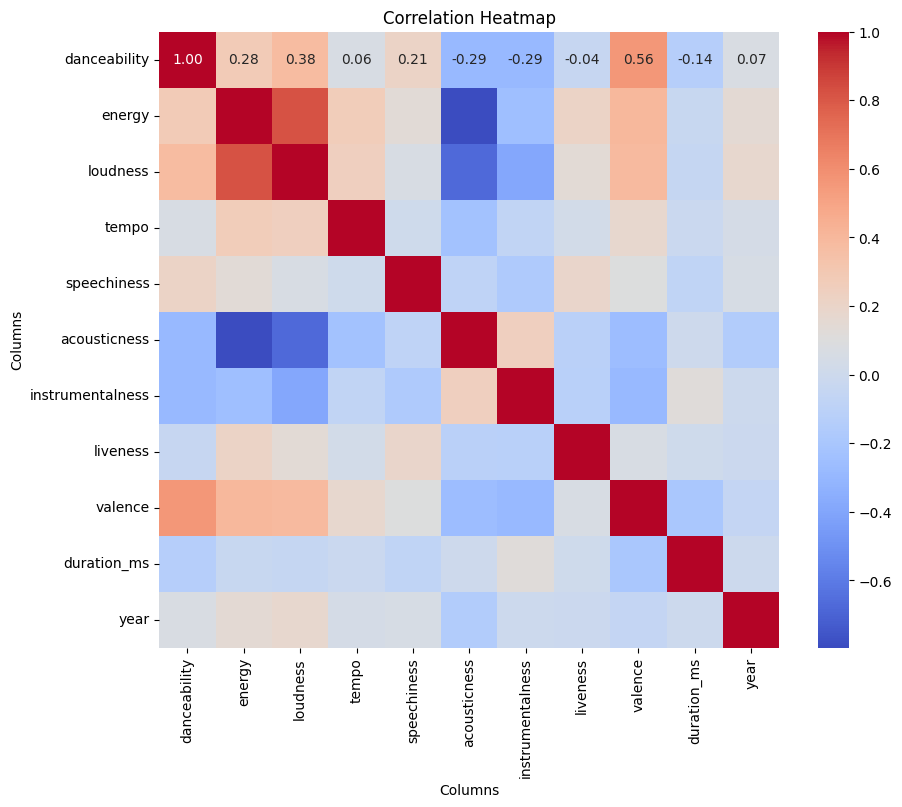

In [19]:
numerical_columns = ["danceability", "energy", "loudness", "tempo", 
                 "speechiness", "acousticness", "instrumentalness", 
                 "liveness", "valence", "duration_ms", "year"]

numerical_df = spotify_data_clean.select(*numerical_columns)

assembler = VectorAssembler(inputCols=numerical_df.columns, outputCol="features")
feature_vector = assembler.transform(numerical_df)

pearson_corr = Correlation.corr(feature_vector, "features").head()
correlation_matrix = pearson_corr[0].toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=numerical_columns, yticklabels=numerical_columns)
plt.title("Correlation Heatmap")
plt.xlabel("Columns")
plt.ylabel("Columns")
plt.show()




In [20]:
av = spotify_data_clean.groupBy("year") \
                          .agg(avg("danceability").alias("avg_danceability"),
                              avg("energy").alias("avg_energy"),
                              avg("speechiness").alias("avg_speechiness"),
                              avg("mode").alias("avg_mode"),
                              avg("acousticness").alias("avg_acousticness"),
                              avg("instrumentalness").alias("avg_instrumentalness"),
                              avg("liveness").alias("avg_liveness"),
                              avg("valence").alias("avg_valence")) \
                          .orderBy("year").filter(sqlf.col("year") > 1970)


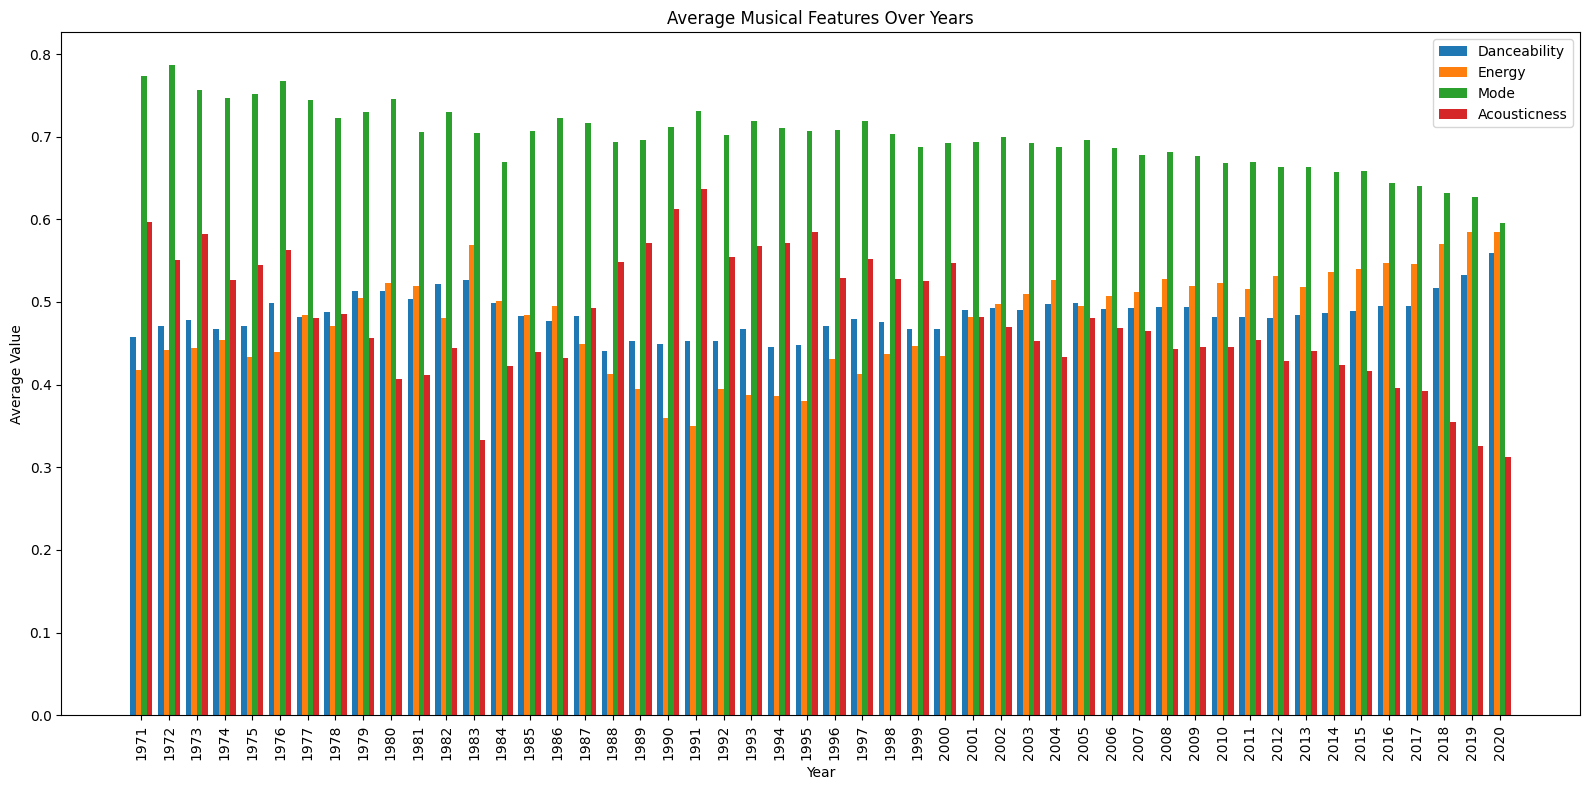

In [31]:
years = av.select("year").rdd.flatMap(lambda x: x).collect()
features = ["avg_danceability", "avg_energy", 
            "avg_mode", "avg_acousticness"]

# colors = ['b', 'g', 'r', 'c']
bar_width = 0.2
positions = np.arange(len(years))

# Create Bar Plot
plt.figure(figsize=(16, 8))

for i, feature in enumerate(features):
    values = av.select(feature).rdd.flatMap(lambda x: x).collect()
    plt.bar(positions + i*bar_width, values, bar_width, label=feature.split("_")[1].capitalize())

plt.xlabel('Year')
plt.ylabel('Average Value')
plt.title('Average Musical Features Over Years')
plt.xticks(positions + 0.3, years)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


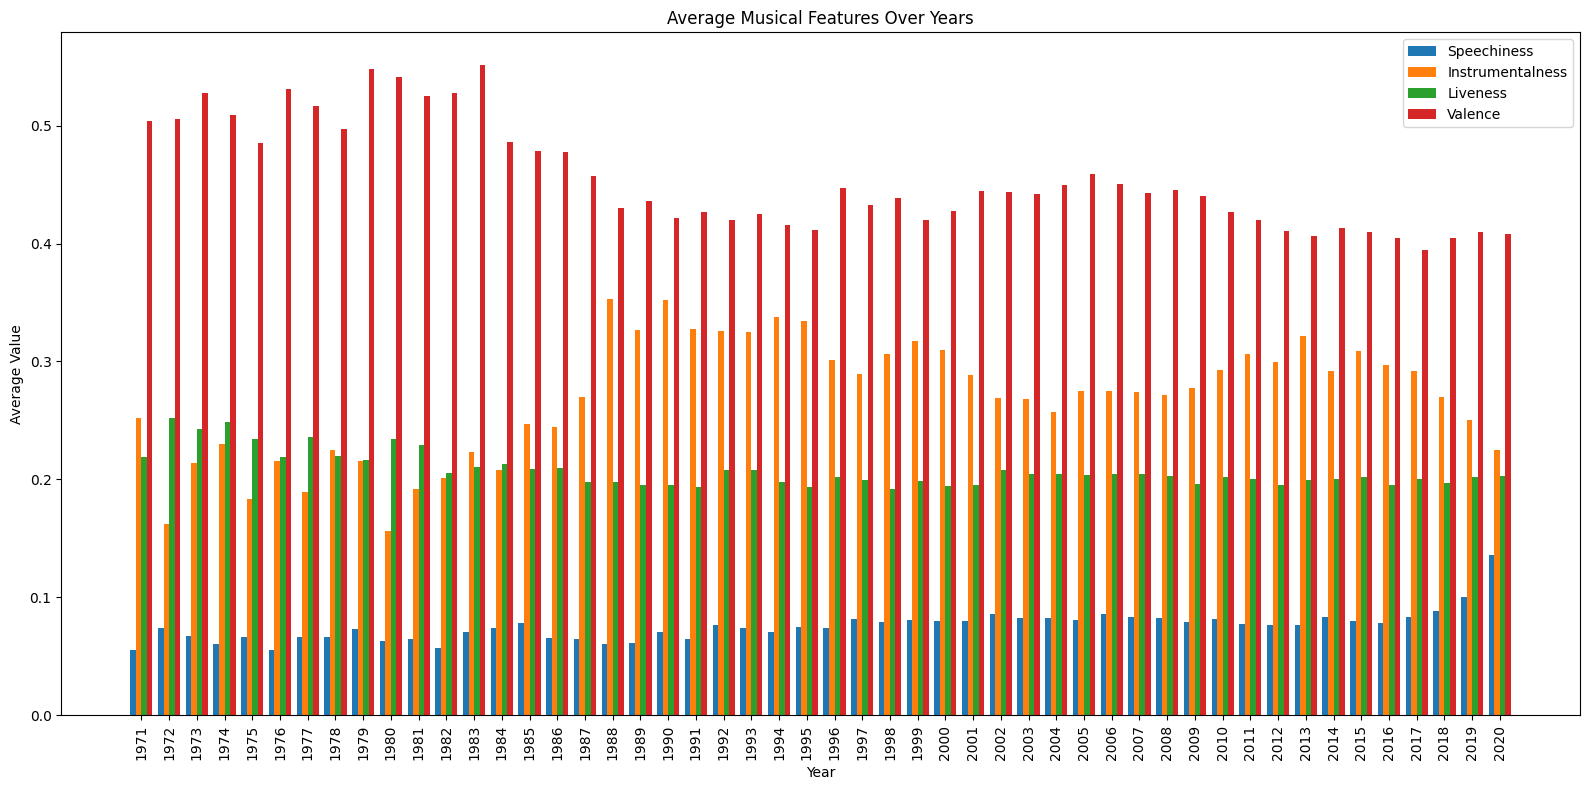

In [30]:
years = av.select("year").rdd.flatMap(lambda x: x).collect()
features = ["avg_speechiness", 
            "avg_instrumentalness", 
            "avg_liveness", "avg_valence"]

bar_width = 0.2
positions = np.arange(len(years))

# Create Bar Plot
plt.figure(figsize=(16, 8))

for i, feature in enumerate(features):
    values = av.select(feature).rdd.flatMap(lambda x: x).collect()
    plt.bar(positions + i*bar_width, values, bar_width, label=feature.split("_")[1].capitalize())

plt.xlabel('Year')
plt.ylabel('Average Value')
plt.title('Average Musical Features Over Years')
plt.xticks(positions + 0.3, years)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
explicit_percentage_df = spotify_data_clean.groupBy("year") \
                           .agg(avg(sqlf.col("explicit").cast("int")).alias("explicit_percentage")) \
                           .orderBy("year") \
                           .filter(sqlf.col("year") > 1970)

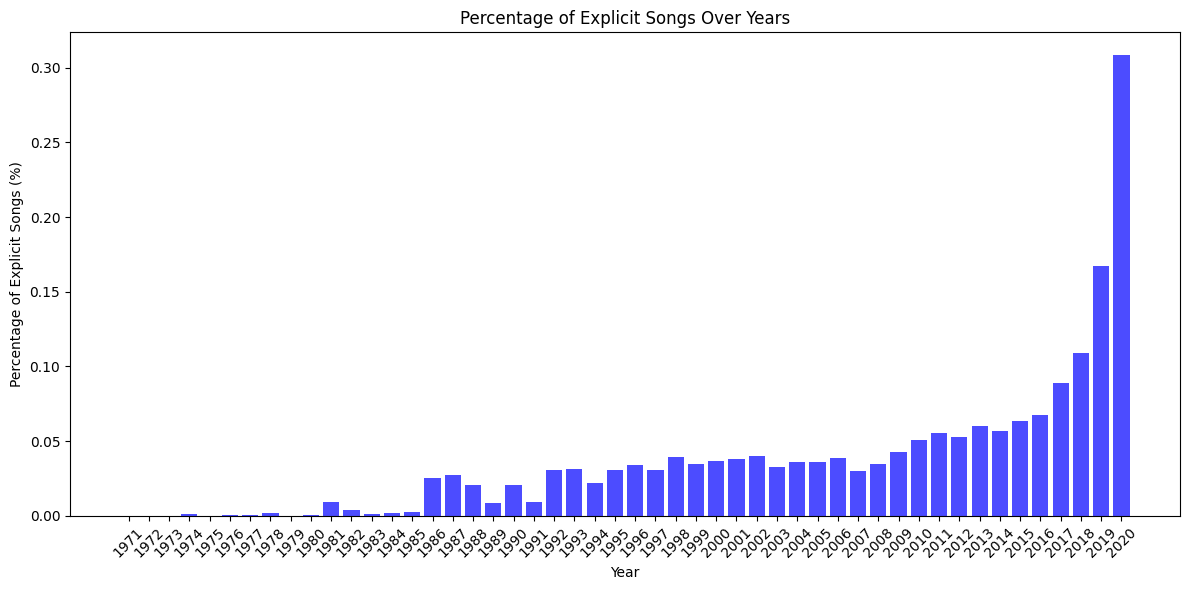

In [35]:
explicit_percentage = explicit_percentage_df.select("explicit_percentage").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.bar(years, explicit_percentage, color='blue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Percentage of Explicit Songs (%)')
plt.title('Percentage of Explicit Songs Over Years')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

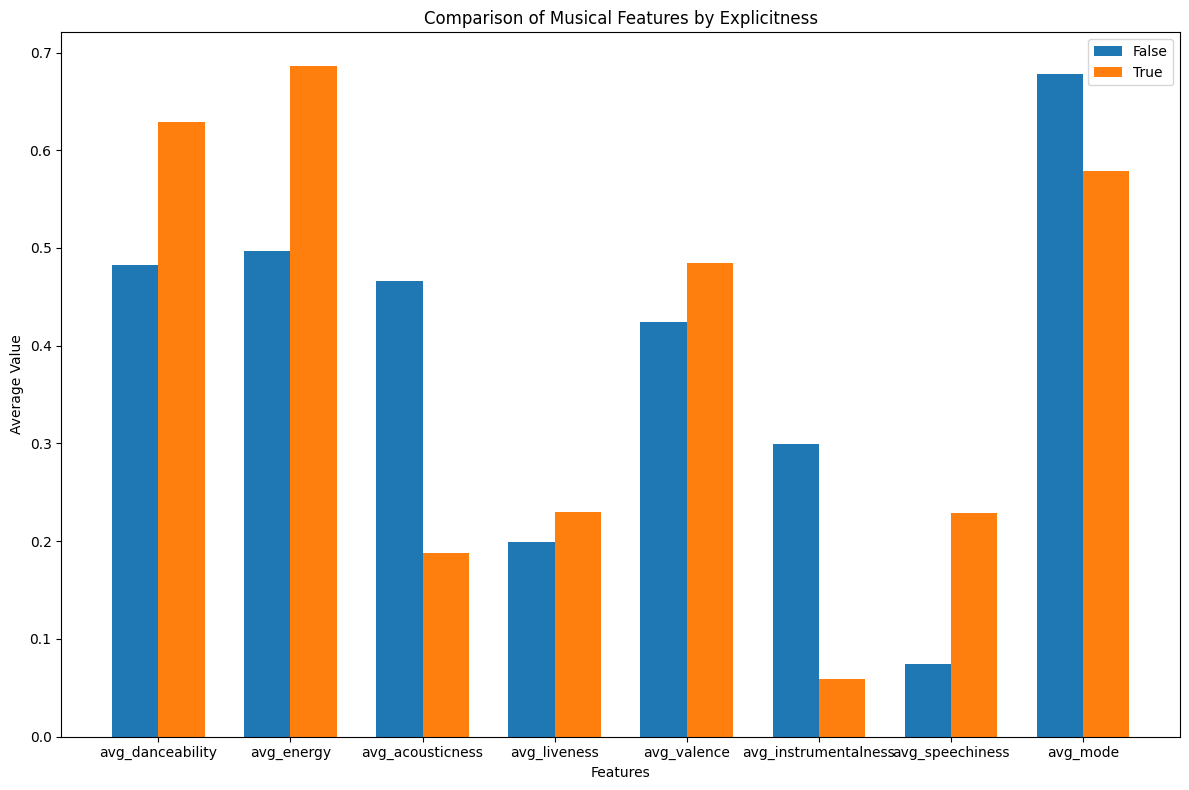

In [44]:
avg_values_df = spotify_data_clean.groupBy("explicit") \
                  .agg(avg("danceability").alias("avg_danceability"),
                       avg("energy").alias("avg_energy"),
                       avg("acousticness").alias("avg_acousticness"),
                       avg("liveness").alias("avg_liveness"),
                       avg("instrumentalness").alias("avg_instrumentalness"),
                       avg("speechiness").alias("avg_speechiness"),
                       avg("mode").alias("avg_mode"),
                       avg("valence").alias("avg_valence")) \
                  .orderBy("explicit")

# Extract data for plotting
features = ["avg_danceability", "avg_energy", "avg_acousticness", "avg_liveness", "avg_valence", "avg_instrumentalness", "avg_speechiness", "avg_mode"]
labels = ["False", "True"]
values = avg_values_df.select(features).rdd.flatMap(lambda x: x).collect()

# Create Side-by-Side Bar Plot
x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, values[:8], width, label=labels[0])
rects2 = ax.bar(x + width/2, values[8:], width, label=labels[1])

ax.set_xlabel('Features')
ax.set_ylabel('Average Value')
ax.set_title('Comparison of Musical Features by Explicitness')
ax.set_xticks(x)

ax.set_xticklabels(features)
ax.legend()

plt.tight_layout()
plt.show()
